## **Handling Imbalance data and Feature Selection**

- **Undersampling**: It reduces the size of the majority class by randomly removing instances to match the minority class size, creating a balanced dataset. This approach is efficient but risks discarding valuable data, which can reduce model accuracy.

- **Oversampling**: It involves increasing the minority class size by duplicating or synthetically generating instances, such as through SMOTE (Synthetic Minority Over-sampling Technique). Oversampling retains all data but can increase the risk of overfitting, as the model might "memorize" synthetic instances rather than generalizing well.

- **Dimensionality Reduction using PCA**: Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms a large set of variables into a smaller one while preserving as much variance (information) as possible. PCA works by finding new, uncorrelated axes (principal components) that capture the maximum variance in the data. The first few components retain the most important patterns, enabling us to reduce the number of features, minimize redundancy, and simplify complex datasets. 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math 

**Data**

In [2]:
# Load the data
try:
    data = pd.read_csv('data_versions/04_log_scaled_data.csv', index_col=False)
    print(f"Successfully loaded {len(data.columns)} features")
except Exception as e: 
    print(f"Error loading data: {e}")

Successfully loaded 87 features


**Steps**

### **Sampling for Imbalance Dataset**

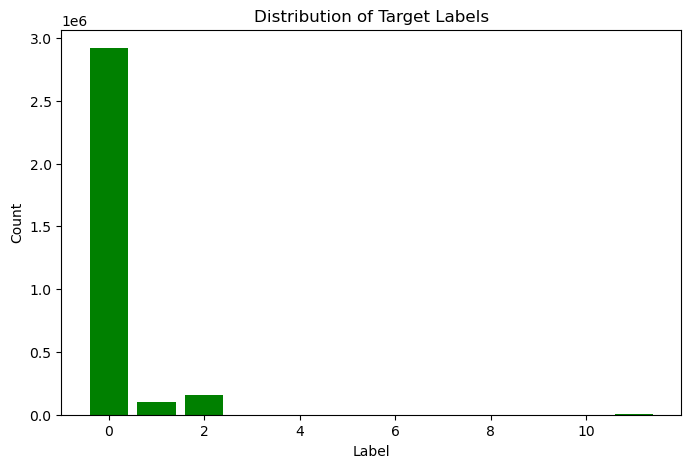

In [3]:
# Lets understand the data imbalance first

# target distribution
sample = {
    'Label': [0.0, 2.0, 1.0, 11.0, 8.0, 6.0, 3.0, 4.0, 7.0, 10.0, 5.0, 9.0],
    'Count': [2919574, 155931, 103944, 8722, 822, 193, 168, 163, 131, 48, 36, 34]
}

sample = pd.DataFrame(sample)

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.bar(sample['Label'], sample['Count'], color='green')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Target Labels')
plt.show()

> Highly imbalanced dataset, can create biasness in the model, due to number of instances in majority class

In [4]:
import sklearn 
print(sklearn.__version__)

1.2.2


In [5]:
len(data)

3189766

**PCA**

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Separate the features and the target variable 
X = data.iloc[:, :-1]  # last column is the target
y = data.iloc[:, -1]

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X)

In [8]:
X_pca.shape

(3189766, 86)

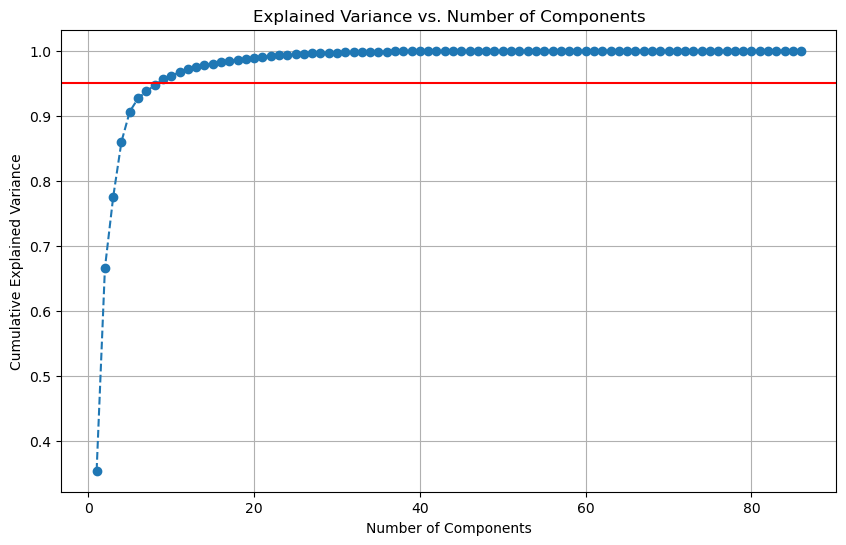

In [9]:
# Calculate cumulative explained variance
cumulative_variance = pca.explained_variance_ratio_.cumsum()

# Plot cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.axhline(y=0.95, color='r', linestyle='-')
plt.grid(True)
plt.show()

In [10]:
# Choose number of components to retain 95% variance
n_components_95 = next(i for i, total_variance in enumerate(cumulative_variance, start=1) if total_variance >= 0.95)
print(f"Number of components to retain 95% variance: {n_components_95}")

Number of components to retain 95% variance: 9


In [11]:
# Apply PCA with the chosen number of components
pca = PCA(n_components=n_components_95)
X_reduced = pca.fit_transform(X)

# Check the shape of the reduced dataset
print(f"Reduced dataset shape: {X_reduced.shape}")

Reduced dataset shape: (3189766, 9)


In [13]:
# X_reduced is the array obtained after applying PCA
# Convert X_reduced to a DataFrame
n_components = X_reduced.shape[1]
column_names = [f'PC{i+1}' for i in range(n_components)]
data_pca = pd.DataFrame(X_reduced, columns=column_names)

# target variable y, add it back to the DataFrame
data_pca['target'] = y.values

# Check the first few rows of the new DataFrame
data_pca.head(3)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,target
0,20.936625,22.573121,23.138820,-6.392429,-8.800306,19.088731,21.415186,-5.960393,7.782282,0.0
1,37.081262,-4.223053,27.600323,2.911581,12.592248,-6.329941,0.506592,0.899280,1.378870,0.0
2,25.393192,21.099114,29.589979,-7.090512,-10.810156,15.539835,15.566973,-3.688899,8.858703,0.0


**Undersampling**

In [27]:
from imblearn.under_sampling import RandomUnderSampler

# Separate features and target after PCA
X_red = data_pca.drop(columns=['target'])
y_red = data_pca['target']

# underSampling strategy 
undersampling_strategy = {0: 10000, 1: 8000, 2: 5000}

# Apply Random Undersampling to handle class imbalance
rus = RandomUnderSampler(sampling_strategy=undersampling_strategy, random_state=42)
X_res, y_res = rus.fit_resample(X_red, y_red)

# Convert the resampled arrays back to a DataFrame
data_undersampled = pd.DataFrame(X_res, columns=column_names)
data_undersampled['target'] = y_res

# Check the distribution after resampling
print('Resampled dataset shape:', Counter(y_res))

Resampled dataset shape: Counter({0.0: 10000, 11.0: 8722, 1.0: 8000, 2.0: 5000, 8.0: 822, 6.0: 193, 3.0: 168, 4.0: 163, 7.0: 131, 10.0: 48, 5.0: 36, 9.0: 34})


**Oversampling**

using **SMOTE** to over-sample the minority labels

In [32]:
from imblearn.over_sampling import SMOTE
from collections import Counter

# Separate features and target after PCA
X_reduced = data_undersampled.drop(columns=['target'])
y_reduced = data_undersampled['target']

# define sampling strategy 
oversampling_strategy = {8: 4000, 6: 3000, 3: 2000, 4: 2000, 7: 2000, 10: 1800, 5: 1500, 9: 1500}

# Apply SMOTE to handle class imbalance
smote = SMOTE(sampling_strategy=oversampling_strategy, random_state=42)
try:
    X_resampled, y_resampled = smote.fit_resample(X_reduced, y_reduced)
    print(f"Data Over-Sampled!")
except Exception as e: 
    print(f"Error {e}")

Data Over-Sampled!


In [34]:
# Convert the resampled arrays back to a DataFrame
df_resampled = pd.DataFrame(X_resampled, columns=column_names)
df_resampled['target'] = y_resampled

# Check the distribution after resampling
print('Resampled dataset shape:', Counter(y_resampled))
# print(df_resampled.head())

Resampled dataset shape: Counter({0.0: 10000, 11.0: 8722, 1.0: 8000, 2.0: 5000, 8.0: 4000, 6.0: 3000, 3.0: 2000, 4.0: 2000, 7.0: 2000, 10.0: 1800, 5.0: 1500, 9.0: 1500})


**Save the data frames**

In [42]:
data_pca.to_csv('data_versions/05_data_pca.csv')
df_resampled.to_csv('data_versions/05_resampled_data.csv')